In [1]:
import numba, os, sys, time, pickle, resource, copy, subprocess, multiprocessing
import astropy.units as u, matplotlib.pyplot as plt
import numpy as np, scipy.ndimage as ndimage
from datetime import datetime, timedelta
from sys import path
from tqdm.auto import tqdm
import pickle
import glob

from numpy.random import Generator, PCG64

import sunpy
from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord
from astropy.io import fits
import importlib

crobar_path = os.path.join('../crobar/python_modules/')
path.append(crobar_path)
from local_cartesian_transform import planar_map_coords, curved_map_coords, transform, transform_curved, wrld2pix
from loop_processing import filter_loops, resample_loops
from initial_points import volume_seed_points, fluxweighted_seed_points, region_seed_points, hilbert_seed_points
from label_loop_regions import label_loop_regions
from coord_grid import coord_grid
import forcefree_field
from util import estimate_aia_error, search_fido_response, bindown2, get_limb, get_limb_occlusion
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission

path.append('../codebase')
from aia_noise import aia_noise
from misc_io import get_croprs, get_map, get_bounds, bounds2grid

ebtel_path ="../ebtelPlusPlus/" #nanoflare->ebtelplusplus
ebtel_bin_path = ebtel_path+"bin/ebtel++.run"

plt.rcParams.update({'font.size': 18,'figure.figsize':[16,8],'image.origin':'lower'})

In [2]:
newpoints = False # Generate a new set of footpoints (requires a full simulation rerun)
newtrace = False # Retrace the field lines (e.g., if alpha changes)
newfilter = False # Refilter the traced loops to cull those that are too close together
newmatrix = False # Compute a new forward matrix for CROBAR inversion
run_amat_gen = False # Generate the general forward matrix amat(x,y,loop,segment)
heating_model_gen=False # Regenerate the heating for each loop
run_ebtel = True # Run the EBTEL heating simulations
run_batch = True # Generate full set of images

In [3]:
# Save files and arguments that need to go in the save file names:
save_dir = '../files/save'
magnetogram_dir = '../files/data'
emission_dir = '../files/save'

# note, the following two files need to have been created externally. 
magnetogram_name = 'hmi.m_45s.2020.04.28_11_13_30_TAI.magnetogram.fits'
emis_name = 'radloss_iswat_042820.fits'
alpha = 3/1.0e11
alphastr = str(round(alpha/1.0e-11,3))

date = '2020/04/28 11:13:30'
datestr = '20200428_111330'

footpoint_savefile = os.path.join(save_dir,'footpoints_'+datestr+'.npz')
loop_savefile = os.path.join(save_dir,'loops_'+datestr+'_'+alphastr+'.npz')
loopid_savefile = os.path.join(save_dir,'loopids_'+datestr+'_'+alphastr+'.npz')
emis_configfile = os.path.join(save_dir,'emconfig_'+'_'+datestr+'_'+alphastr+'.npz')
emis_savefile = os.path.join(save_dir,'em3d_'+emis_name[0:-4]+'_'+datestr+'_'+alphastr+'.npz')
limb_savefile = os.path.join(save_dir,'limb_mask_'+datestr+'_'+alphastr+'.npz')
area_savefile = os.path.join(save_dir,'loop_areas_3.0.npz')
em3d_savefile = os.path.join(save_dir,'hmap_cube_bindown3.npz')

In [4]:
footpoint_config = dict(np.load(footpoint_savefile,allow_pickle=False))
loop_config = dict(np.load(loop_savefile,allow_pickle=False))
emis_config = dict(np.load(emis_configfile,allow_pickle=False))
loopid_info = dict(np.load(loopid_savefile,allow_pickle=False))
loop_areas = dict(np.load(area_savefile,allow_pickle=False))
em3d_output = dict(np.load(emis_savefile,allow_pickle=False))

In [5]:
length_unit = u.Unit(str(footpoint_config['length_unit']))
pos_unit = u.Unit(str(footpoint_config['pos_unit']))

magnetogram_path = os.path.join(magnetogram_dir,str(footpoint_config['magnetogram_name']))
emis_path = os.path.join(emission_dir,str(emis_config['emis_name']))

In [6]:
cropr, cropr_emis = get_croprs(footpoint_config)
magnetogram = get_map(magnetogram_path, cropr)
emis_map = get_map(emis_path, cropr_emis)

In [7]:
gfac = 1.0/3
# An arcsecond from one AU
asec_cm = 1.49e13/(3600*180/np.pi)
flux_factor = loop_config['dvox'][0]*loop_config['dvox'][1]
rsun_cm = magnetogram.center.rsun.to(length_unit).value
footpoint_config['rsun_cm'] = rsun_cm

In [8]:
# Get the 'local' coordinate system for the magnetogram. In this coordinate system,
# the radial axis at image center (not necessarily coordinate center due to solar
# curvature) is the z axis, and the x axis is aligned with solar longitude.
vox_lct = transform_curved(magnetogram.center)

# Compute the coordinates of the magnetogram pixels and the magnetic field strengths
# corrected for inclination by assuming that the surface fiels are radial. Points too far
# from disk center are masked out. This code will also attempt to correct the line-of-sight
# fields to radial by assuming the field lines on the photosphere are radial.
[mag, mag_coords, good_mask] = curved_map_coords(magnetogram,lct=vox_lct)
mag_coords = mag_coords.to(length_unit).value

In [9]:
bounds0, tracer_bounds = get_bounds(mag_coords, footpoint_config, loop_config)
# This is the grid for the voxels:
vox_grid = bounds2grid(bounds0,loop_config['dvox'],offsets=footpoint_config['bounds_offset'],pad=loop_config['vox_boundpad'])
# This is the grid used for generating initial points and filtering them:
flt_grid = bounds2grid(bounds0,loop_config['dvox']*loop_config['flt_dvox_fac'],offsets=footpoint_config['bounds_offset'])
vox0, dvox, nvox = vox_grid.origin, np.diag(vox_grid.fwd), vox_grid.dims
print(vox0, dvox, nvox)

[-1.64535932e+10 -1.69383115e+10 -4.22539499e+09] [14000000. 14000000. 14000000.] [2298 2399 1951]


In [10]:
# Unpack the coordinates from the loop config file:
fieldline_coords0 = [loop_config['fieldlines0'][loop_config['fieldline_indices0']==i] for i in range(0,loop_config['fieldline_indices0'][-1])]

if(newfilter):
	# Resample loops so that they're regularly spaced, and footpoints are at the photosphere (open ends exempted):
	[fieldlines_resamp,lengths] = resample_loops(fieldline_coords0,tracer_bounds,0.1*np.mean(dvox),rcurv=rsun_cm)
	
	# Filter out loops whose footpoints fall too close together:
	[fieldlines_filter,lengths_filter] = filter_loops(fieldlines_resamp, lengths, flt_grid, 
													  lmin=loop_config['min_length'], 
													  zmin = loop_config['min_height'], rcurv=rsun_cm)
	fieldline_indices = np.hstack([i*np.ones(fieldlines_filter[i].shape[0],dtype=np.int32) for i in range(0,len(fieldlines_filter))])
	loop_config['fieldline_indices'] = fieldline_indices
	loop_config['fieldlines_filter'] = np.vstack(fieldlines_filter)
	loop_config['lengths_filter'] = np.hstack(lengths_filter)
	np.savez_compressed(loop_savefile,**loop_config)
else:
	fieldlines_filter = [loop_config['fieldlines_filter'][loop_config['fieldline_indices']==i] for i in tqdm(range(0,loop_config['fieldline_indices'][-1]+1))]
	lengths_filter = [loop_config['lengths_filter'][loop_config['fieldline_indices']==i] for i in tqdm(range(0,loop_config['fieldline_indices'][-1]+1))]

nloops = len(fieldlines_filter)
print(nloops)

  0%|          | 0/9291 [00:00<?, ?it/s]

  0%|          | 0/9291 [00:00<?, ?it/s]

9291


In [11]:
# Unpack the forward matrix from the configuration:
from scipy.sparse import csr_matrix
amat = csr_matrix((emis_config['amat_data'],emis_config['amat_indices'],emis_config['amat_indptr']), shape=emis_config['amat_shape'])
emis_config['map'] = emis_map # restore the emission map

test that we recover our AIA reconstruction produced in `reconstruction.ipynb`

[Text(0.5, 1.0, 'Reconstruction of original AIA image')]

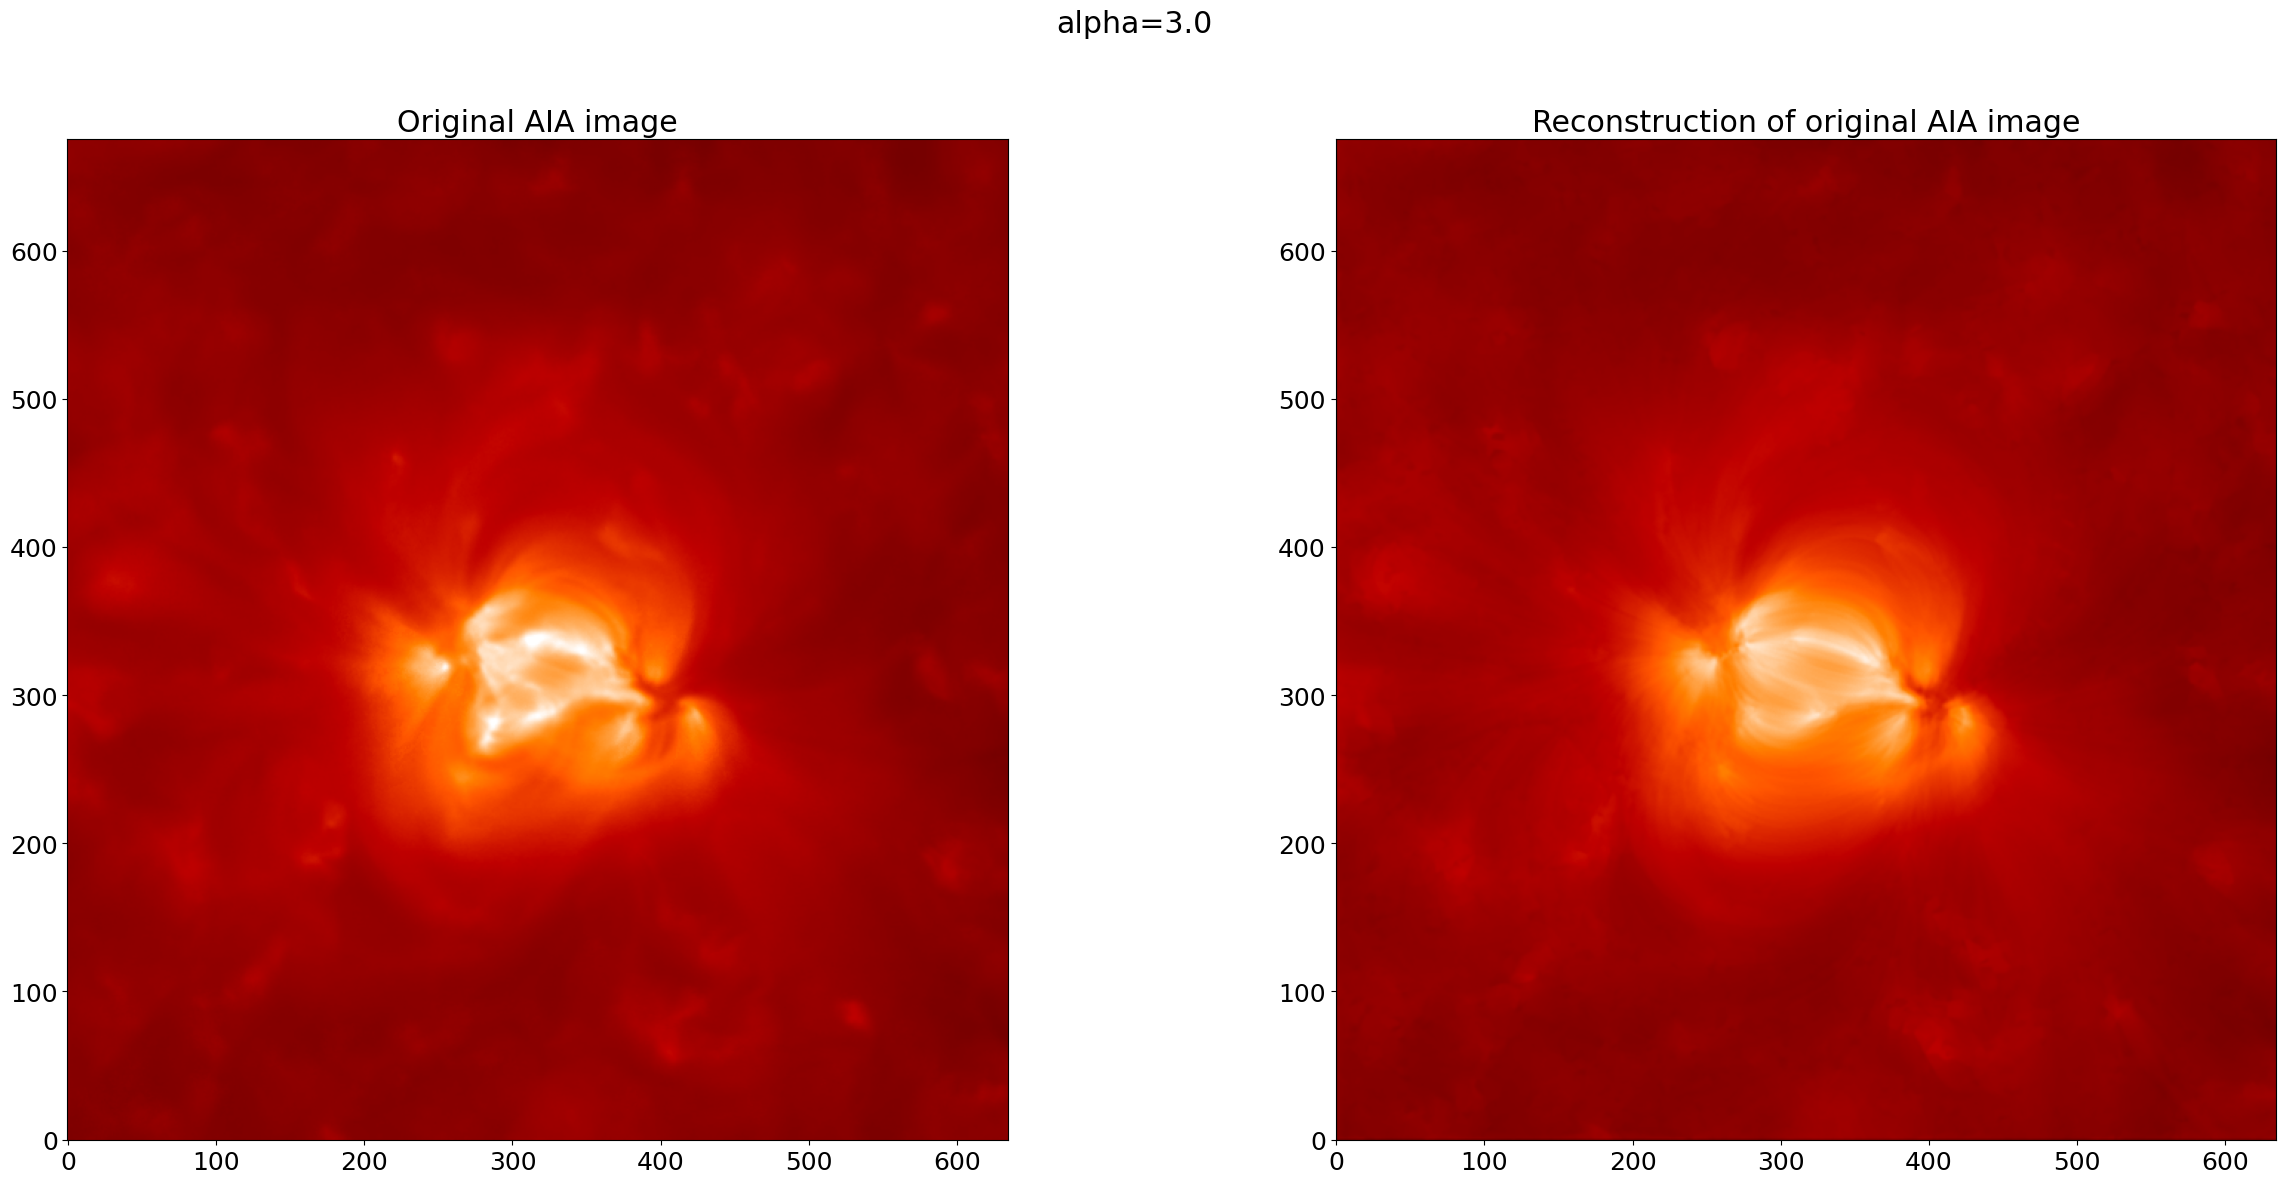

In [12]:
data_corr = emis_config['map'].data
gfac = 1.0/3

solution = em3d_output['solution']
soln = copy.deepcopy(solution)/emis_config['loop_weights']
aia_only_recon_dat_aia = (amat.T.dot(emis_config['loop_weights']*soln)).reshape(emis_config['map'].data.shape)

pltmax = 1000000

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[30,13])
plt.suptitle('alpha='+alphastr)
axes[0].imshow(data_corr**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[0].set(title='Original AIA image')
axes[1].imshow(aia_only_recon_dat_aia**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[1].set(title='Reconstruction of original AIA image')

In [13]:
import reconstruct_2comp_3Dloops 
importlib.reload(reconstruct_2comp_3Dloops)
from reconstruct_2comp_3Dloops import general_fwdmat

amat_savefile = os.path.join(save_dir,'amat_heating_config_a'+alphastr+'.npz')
print(amat_savefile)

limb_mask_load = np.load(limb_savefile)

if run_amat_gen:
    amat_gen, modelinput_gen = general_fwdmat(emis_map, loopid_info, magnetogram, vox_mask=limb_mask_load['arr_0'], loud=False, bin_fac=1, psf_size_px=0.5)
    
    modelinput_gen.pop('map')
    np.savez_compressed(amat_savefile,
                       # Sparse matrix components
                       amat_data=amat_gen.data,
                       amat_indices=amat_gen.indices,
                       amat_indptr=amat_gen.indptr,
                       amat_shape=amat_gen.shape,
                       # modelinput_gen
                       vox_xy2=modelinput_gen['vox_xy2'],
                       psfnorm=modelinput_gen['psfnorm'],
                       psfnorm2=modelinput_gen['psfnorm2'],
                       rsun_cm=modelinput_gen['rsun_cm'])
else:
    from scipy.sparse import csc_matrix
    amat_heating_config = np.load(amat_savefile)
    amat_gen = csc_matrix(
        (amat_heating_config['amat_data'], amat_heating_config['amat_indices'], amat_heating_config['amat_indptr']), 
        shape=amat_heating_config['amat_shape'])

../files/save/amat_heating_config_a3.0.npz


In [14]:
heating_path = os.path.join('../CROBAR-heating/heating_modules/')
path.append(heating_path)

note: we are not using the most up-to-date version of the repository. Instead, to have the following work correcly, you need to install/revert to commit `608ed0f16ba705bd0d92d34a9223b5bfc820549d`. This version will have the correct heating_modules.

In [15]:
import loopset
importlib.reload(loopset)

dummy_mags = [0*vec[:,1] for vec in fieldlines_filter]
loopnames = np.copy(loopid_info['loopnames']).tolist() # put this into loopset (?)
ar = loopset.loopset.get_loops(fieldlines_filter,dummy_mags,lengths_filter,loopnames=loopnames)

In [16]:
loop_volumes = loop_areas['area_norms']*loop_areas['loop_amaxes']*loopid_info['looplengths'][0:nloops]
loopid_info['loop_volumes']=loop_volumes

In [17]:
from processify import processify
import volumetric_poisson_powerlaw_nanoflares as vppnf


importlib.reload(vppnf)
heating_model = vppnf.volumetric_poisson_powerlaw_nanoflares(loopid_info)

In [18]:
#t_tot = 1.5e4*u.s
t_tot = 86400*u.s # 24hrs
heat_fac = 0.6 #140/27/7 # Too large compared to previous runs by a factor for 540, for some reason?

In [19]:
hmap_dict = np.load(em3d_savefile)
print(hmap_dict.keys())
hmap = hmap_dict['hmap']*(heat_fac/(u.erg/u.s/u.cm**3))

#hmap = em3d*limb_mask
hmx = vox0[0]+hmap_dict['xa']*dvox[0]
hmy = vox0[1]+hmap_dict['ya']*dvox[1]
hmz = vox0[2]+hmap_dict['za']*dvox[2]

KeysView(NpzFile '../files/save/hmap_cube_bindown3.npz' with keys: hmap, xa, ya, za)


In [20]:
heating_options = {
	'duration':200.0*u.s,
	'emin':2.0e22*u.erg,
	'emax':1.0e26*u.erg,
	'index': -0.0,
	'h_rate':(5e5*u.erg/u.cm**2/u.s)*0.05,
	't_tot':t_tot,
	'nt':np.round((t_tot/(25*u.s)).value).astype('int32'),
	'stress_level':1, # Doesn't do anything in this code
	'z0':25.0*dvox[2], #540e6,#6000e6,
	'dz0':15.0*dvox[2],#540e6,#2000e6,
	'event_size':np.array(dvox)*5,
	'Bfield_yt':None,
	'nloops':nloops,
	'magnetogram':np.transpose(magnetogram.data),
	'loopnames':loopid_info['loopnames'],
	#'heatmap':1.5*hmap/(u.erg/u.s/u.cm**3),
	'heatmap':hmap,
	'hmxyz':(hmx.astype('float32'),hmy.astype('float32'),hmz.astype('float32')),
	'heating_distribution_name':'../heating_distribution.save',
	'heatmap_factor':1.0,
	'loop_closed':loopid_info['loop_closed']
}

In [21]:
from scipy.interpolate import RegularGridInterpolator

In [22]:
heatmap = copy.deepcopy(heating_options['heatmap'])
heatmap_sz = np.array(heatmap.shape)

heatmap_interp = RegularGridInterpolator(heating_options['hmxyz'],heatmap,fill_value=None,bounds_error=False)

In [23]:
nt = heating_options['nt']
nl = len(loopid_info['looplengths'])

voxmin = -0.5*nvox*dvox
xa,ya = np.indices(nvox[0:2])

xa = voxmin[0] + (0.5+xa)*dvox[0]
ya = voxmin[1] + (0.5+ya)*dvox[1]
za0 = np.zeros(nvox[0:2]) + voxmin[2]  + 0.5*dvox[2] 

In [24]:
interp_z_center = (heating_options['hmxyz'][2].min() + heating_options['hmxyz'][2].max()) / 2

# Shift za0 to be centered on the interpolation range instead of 0
za0 = np.zeros(nvox[0:2]) + interp_z_center - 0.5*(nvox[2]-1)*dvox[2]

In [25]:
print("Voxel coord ranges:")
print(f"xa: {xa.min():.3f} to {xa.max():.3f}")
print(f"ya: {ya.min():.3f} to {ya.max():.3f}")
print(f"za: {(za0 + 0*dvox[2]).min():.3f} to {(za0 + (nvox[2]-1)*dvox[2]).max():.3f}")

print("\nInterpolation grid ranges:")
for i, coord in enumerate(['x', 'y', 'z']):
    print(f"{coord}: {heating_options['hmxyz'][i].min():.3f} to {heating_options['hmxyz'][i].max():.3f}")

Voxel coord ranges:
xa: -16079000000.000 to 16079000000.000
ya: -16786000000.000 to 16786000000.000
za: -4225394816.000 to 23074605184.000

Interpolation grid ranges:
x: -16432592896.000 to 15697406976.000
y: -16903311360.000 to 16612688896.000
z: -4204395008.000 to 23053604864.000


In [26]:
gamma_str = str(abs(heating_options['index']))
heat_str = str(heat_fac)

heat_dir = os.path.join(save_dir,'heating')
heatdic_savefile = os.path.join(heat_dir,'heatdict_g'+gamma_str+'_a'+alphastr+'_h'+heat_str+'.npz')
print(gamma_str, heat_str, heatdic_savefile)

0.0 0.6 ../files/save/heating/heatdict_g0.0_a3.0_h0.6.npz


In [27]:
heating_model_gen

False

In [28]:
if heating_model_gen:
    
    loopheat = np.zeros(nl,dtype='float32')
    
    for i in tqdm(range(0,nvox[2])):
        interpvals = heatmap_interp( (xa, ya, za0+i*dvox[2]) )
        loopheat += np.bincount(loopid_info['voxel_loopids'][:,:,i].flatten(), weights = interpvals.flatten(), minlength=nloops) 
    
    loop_heating = copy.deepcopy(loopheat)*voxvol*(t_tot.value)
    total_heat =  1.242498e+29
    
    voxvol = np.prod(dvox)
    
    heat_adjust = total_heat/loop_heating.sum()
    print(heat_adjust)
    loop_heating*=heat_adjust
    print(loop_heating.sum())
    
    h_oft = np.zeros((nl,nt))
    for i in np.arange(0,nl):
        h_oft[i,:] = loop_heating[i]/nt
    
    times = np.linspace(0,t_tot/u.s,nt)
    
    heating_model.times = times
    heating_model.loop_heating = h_oft
    heating_model.duration = heating_options['duration']
    
    heatdict = heating_model.create_events_dict()
    
    np.savez_compressed(heatdic_savefile, **heatdict)
    
    
    #nt = np.round((t_tot/(25*u.s)).value).astype('int32')+1
    #thalf = 0.5*(times[1]-times[0])
    #print(thalf)
    #plt.plot(times,np.sum(h_oft,axis=0)/1.0e22)
    #print(np.mean(np.sum(h_oft,axis=0)/1.0e22))
    #print(np.sum(h_oft))

else:
    heatdict = dict(np.load(heatdic_savefile),allow_pickle=False)
    heating_model.restore_events(heatdict)

In [29]:
loopindex = np.where(heating_model.loopnames == 'loop000100')
dt = (heating_model.times[1]-heating_model.times[0])
lfrac = 1.0
bfrac = 1.0
magmax = 100.0e0

overlap_fraction = 0.0
extended_dt = dt * (1 + overlap_fraction)

#rise_start = heating_model.times[0:-1]*u.s
#rise_end = rise_start+dt*u.s
#decay_start = rise_end*u.s
#decay_end = heating_model.times[1:]*u.s

rise_start = heating_model.times[0:-1]*u.s
rise_end = rise_start + extended_dt*u.s  # Extend the rise time
decay_start = rise_start + extended_dt*u.s  # Start decay at extended rise end
decay_end = rise_start + 2*extended_dt*u.s  # End decay later to create overlap

open_fac = 1.0*heating_model.loop_closed[loopindex[0]]+2.0*(heating_model.loop_closed[loopindex[0]] == 0)
open_fac = open_fac[0]
length = (heating_model.loopid_info['looplengths'][loopindex][0])
loop_length = 1.0*open_fac*length/2.0

magnitude = np.clip((heating_model.loop_heating[loopindex,:].flatten()[:-1])*lfrac*bfrac/heating_model.loop_volumes[loopindex],0,magmax)*u.erg/open_fac
e_tot = np.sum(magnitude)*heating_model.duration.value/2
mag = e_tot/heating_model.times[-1]*np.ones(len(heating_model.times)-1)*np.ones(len(heating_model.times)-1)
mag[0] = 0
mag = mag[mag>0]

mag

<Quantity [1.70663242e-06, 1.70663242e-06, 1.70663242e-06, ...,
           1.70663242e-06, 1.70663242e-06, 1.70663242e-06] erg>

In [30]:
res_uni = heating_model.calculate_uniform_event_properties(ar.loops[100])

(0.0, 1000.0)

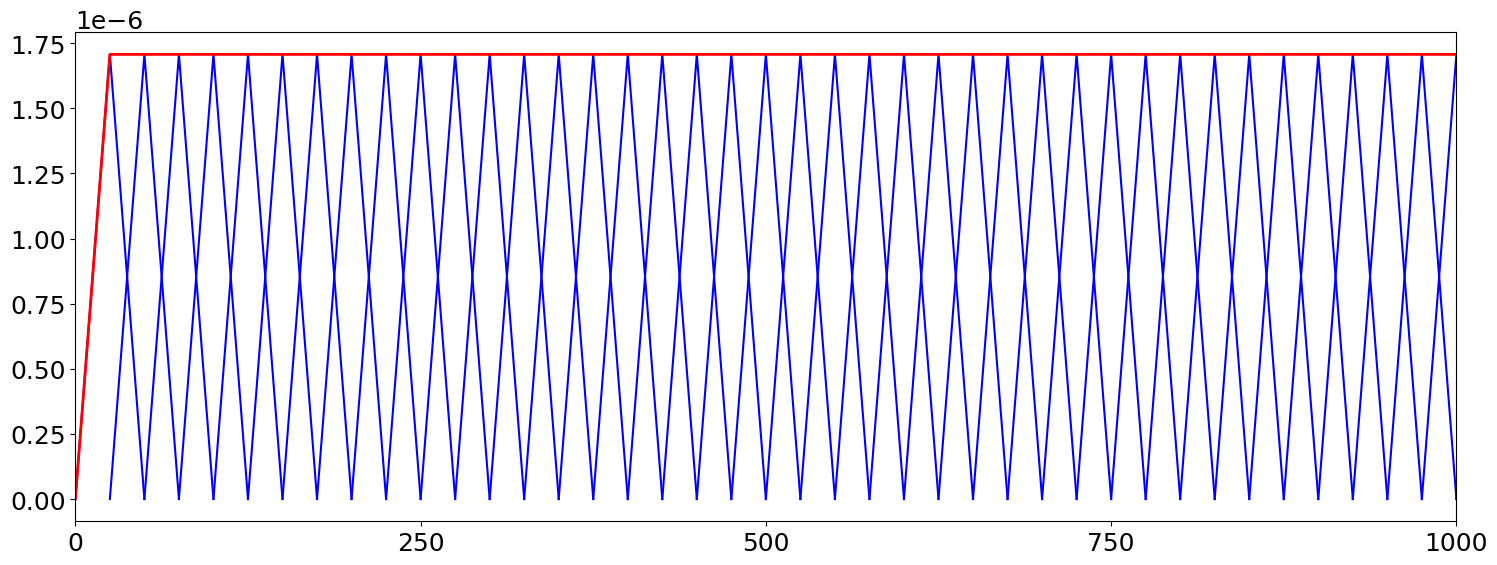

In [31]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator



fig, ax = plt.subplots(figsize=(15, 6))
triangles = []
for i in np.arange(0,len(res_uni['magnitude'])):
    rs,re = res_uni['rise_start'][i].value,res_uni['rise_end'][i].value
    ds,de = res_uni['decay_start'][i].value,res_uni['decay_end'][i].value
    mag = res_uni['magnitude'][i].value
    triangles.append((rs, re, de, mag))

    if re == ds:
        # Define triangle vertices: (x, y) coordinates
        x_points = [rs, re, de]  # Close the triangle by returning to start
        y_points = [0, mag, 0]   # Baseline at 0, peak at mag
        
        ax.plot(x_points, y_points, 'b-')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
plt.tight_layout()


all_points = []
for i, (rs, re, de, mag) in enumerate(triangles):
    all_points.extend([
        (rs, 0, i),
        (re, mag, i),  
        (de, 0, i)
    ])

df = pd.DataFrame(all_points, columns=['time', 'value', 'triangle_id'])

time_grid = np.linspace(0, t_tot.value.astype(int), t_tot.value.astype(int))
total_signal = np.zeros_like(time_grid)

for tid in df['triangle_id'].unique():
    triangle_data = df[df['triangle_id'] == tid].sort_values('time')
    interpolated = np.interp(time_grid, triangle_data['time'], triangle_data['value'])
    total_signal += interpolated

ax.plot(time_grid, total_signal, 'r-', linewidth=2)
ax.set_xlim(0,1000)

7/22 EOD: track location of heating along loop - for HYDRAD

volumetric... `heat_chunk` 2D array (space, time) (?)

In [32]:
synthesizAR_path = os.path.join('../synthesizAR/')
path.append(synthesizAR_path)
import synthesizAR.interfaces.ebtel as ebtel

ebtel_config_template = ebtel_path+"config/ebtel.example.cfg.xml"

run_dir = '../files/runs/'
hydro_config_dir = run_dir+f'heat_config_runs_h{heat_fac}_g{abs(heating_options['index'])}/hydro_config/'
hydro_results_dir = run_dir+f'heat_config_runs_h{heat_fac}_g{abs(heating_options['index'])}/hydro_results/'

#hydro_config_dir = rundir_path+f'heat_config_runs_h{heat_fac}_g{abs(heating_options['index'])}_rlon/hydro_config/' # rad loss on
#hydro_results_dir = rundir_path+f'heat_config_runs_h{heat_fac}_g{abs(heating_options['index'])}_rlon/hydro_results/'

ih = ebtel.util.read_xml(ebtel_config_template) # import read_xml
base_config = ih
base_config['c1_cond0'] = 6.0
base_config['total_time'] = t_tot
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1.0e-7
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0
base_config['use_power_law_radiative_losses'] = True
base_config['save_terms'] = True

In [33]:
import ebtel_interface_uniform
importlib.reload(ebtel_interface_uniform)
from ebtel_interface_uniform import ebtel_interface_lowmem as eil

In [34]:
ebtel_interface = eil(base_config, heating_model, hydro_config_dir, hydro_results_dir)
ar.configure_loop_simulations(ebtel_interface)

In [35]:
print('Total heating: ',np.sum(heating_model.loop_heating))

Total heating:  1.2424980000000002e+29


3595.1909722222267


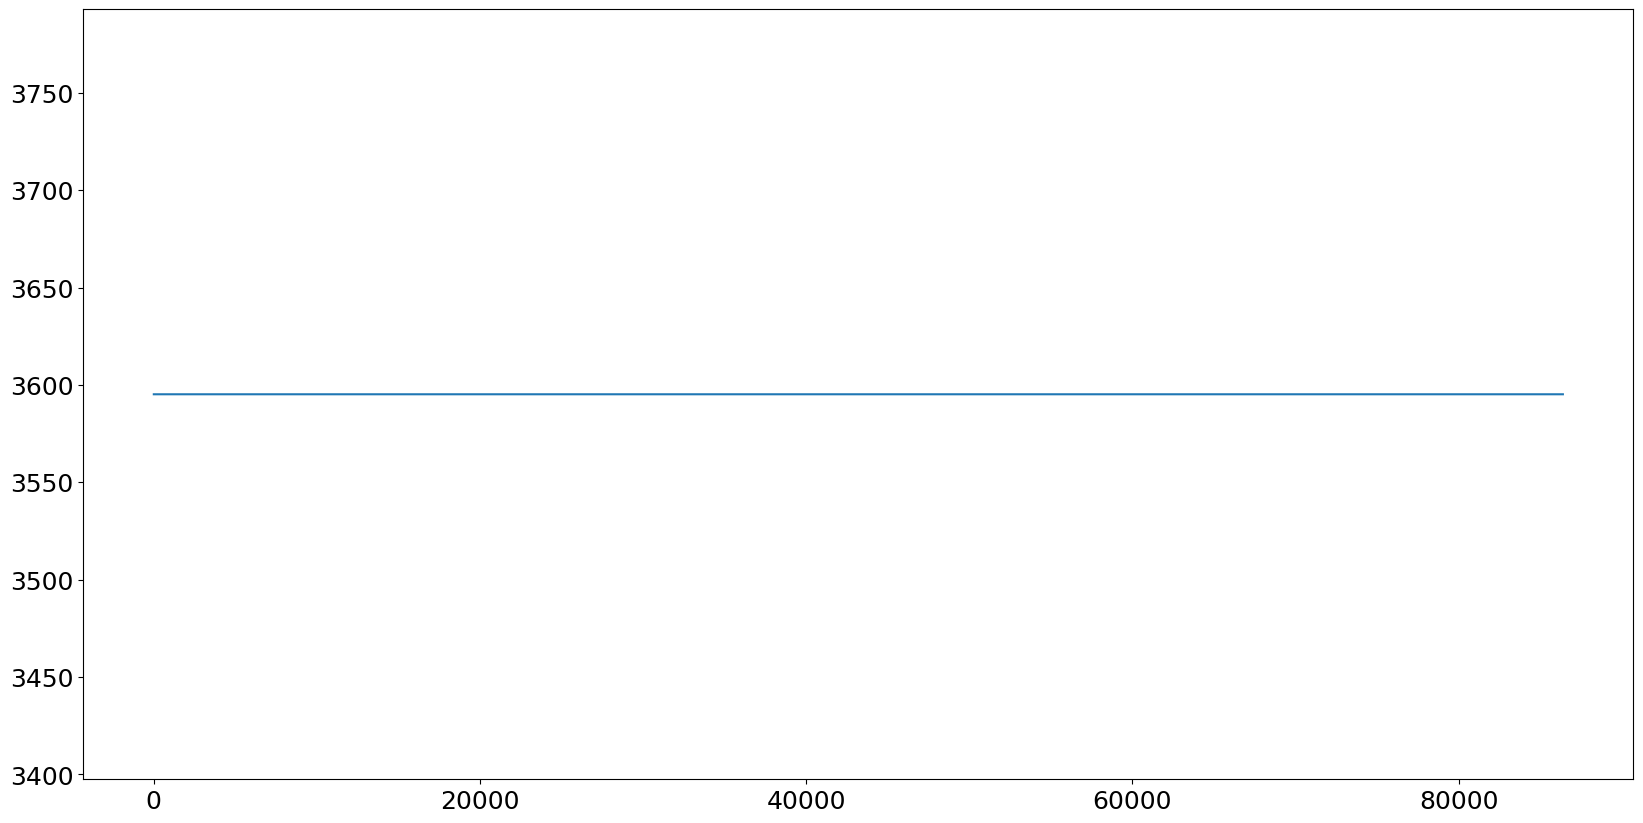

In [36]:
plt.figure(figsize=[20,10])
plt.plot(heating_model.times,np.sum(heating_model.loop_heating,axis=0)/1.0e22)
print(np.mean(np.sum(heating_model.loop_heating,axis=0)/1.0e22))

okay! to run ebtel++ using the following subprocess (e.g. `bin/ebtel++.run`) you need to install via 

`git clone https://github.com/<your-user-name>/ebtelPlusPlus.git` using `ae4a69153f38b95a341c54dad3c199d8fef088c0`. You will need `boost` and `scons` as well, where you can then run

```
$ git clone https://github.com/rice-solar-physics/ebtelPlusPlus.git
$ cd ebtelPlusPlus
$ scons
$ bin/ebtel++.run
```

note: if you install boost via brew, and depending on the version you use, you will need to approprialty update the `SConstruct` file to point to this install. Something like:

```
if 'darwin' in sys.platform:
    print("Using Mac OS X compile options.")
    env.Append(CPPPATH=['/opt/local/include', '/usr/include/malloc','/opt/homebrew/include/'])
    env.Append(LIBS=['boost_program_options'])
    env.Append(LIBPATH=['/opt/homebrew/lib'])
```

you might also need to set `cxx_flags = ['-std=c++14',]`

In [37]:
if(run_ebtel):
	def ebtel_runner(loop):
		#print(loop.name)
		subprocess.call([ebtel_bin_path,
			'-c',loop.hydro_configuration['config_filename']])
	
	results = []
	for loop in tqdm(ar.loops):
	##for loop in ar.loops:
	    ebtel_runner(loop)
    

  0%|          | 0/9291 [00:00<?, ?it/s]

In [38]:
# These cells should load and make a plot of the output:
loop_parameter_filename = run_dir+'ebtel_runs/loop_parameters.h5' # not currently needed in .load_loop_simulations
from load_terms import load_terms

print('Memory usage: %s (kb)' % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
ar.load_loop_simulations(ebtel_interface,loop_parameter_filename)
ebtelterms = []
for loop in ar.loops: ebtelterms.append(load_terms(loop))
print('Memory usage: %s (kb)' % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)

Memory usage: 43183063040 (kb)
Memory usage: 54914187264 (kb)


Memory usage: 54914187264 (kb)


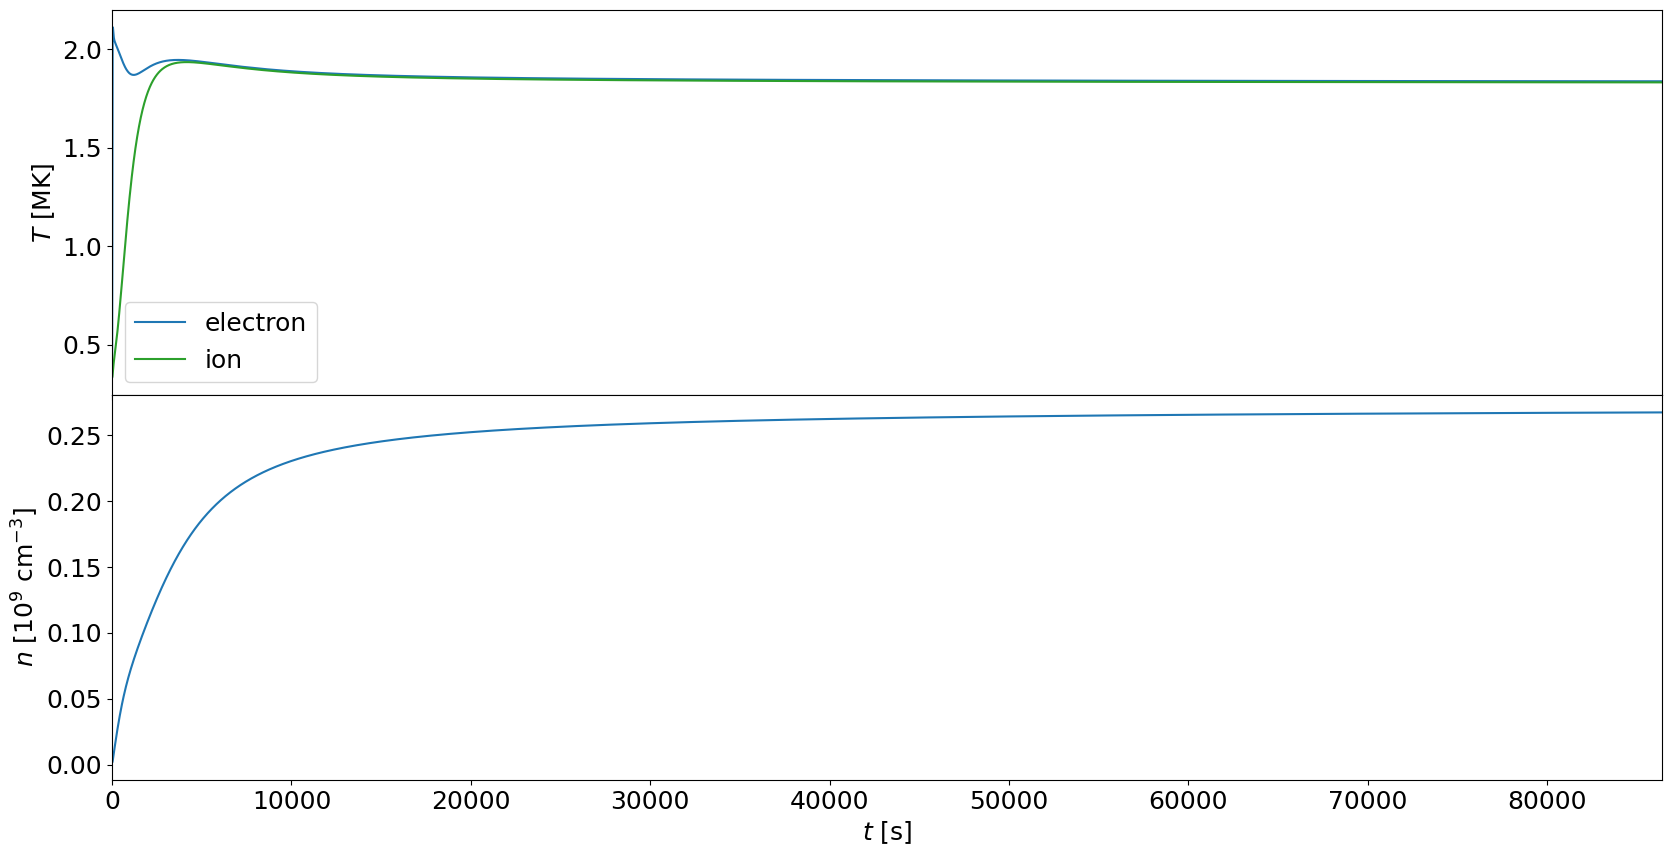

In [39]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
loop=ar.loops[loopid_info['voxel_loopids'][1000,1000,700]]
axes[0].plot(loop.time,loop.electron_temperature/1.0e6,color='C0',label='electron')
axes[0].plot(loop.time,loop.ion_temperature/1.0e6,color='C2',label='ion')
axes[0].legend()
axes[1].plot(loop.time,loop.density/1e9,color='C0')
axes[0].set_xlim([0,base_config['total_time']/u.s])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')
print('Memory usage: %s (kb)' % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)

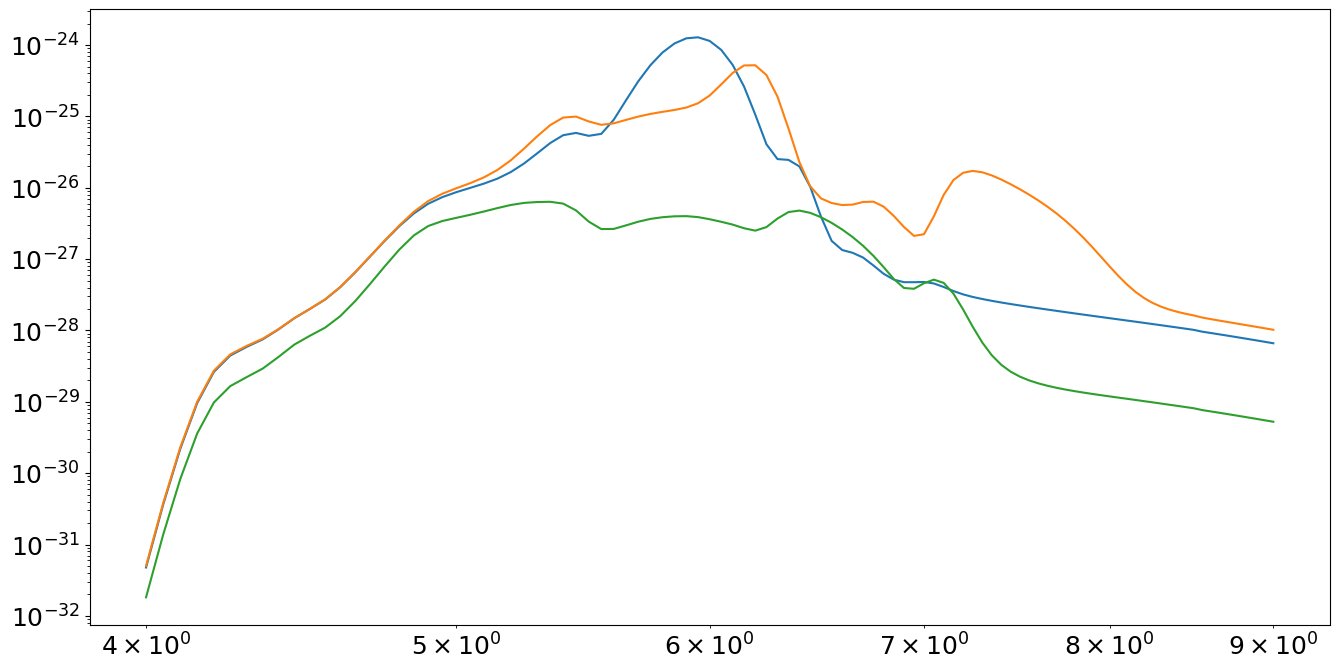

In [40]:
import make_channel_image
importlib.reload(make_channel_image)

import aia
importlib.reload(aia)
from aia import aia_temperature_response

tr171_logt,tr171 = aia_temperature_response(None,channel='AIA171_THIN')
tr193_logt,tr193 = aia_temperature_response(None,channel='AIA193_THIN')
tr335_logt,tr335 = aia_temperature_response(None,channel='AIA335_THIN')

plt.loglog(tr171_logt,tr171)
plt.loglog(tr193_logt,tr193)
plt.loglog(tr335_logt,tr335)

In [41]:
aia_dir = '../files/data'

import glob
fits_files = glob.glob(os.path.join(aia_dir, "*.fits"))
fits_files

aia193dat_path = None
aia335dat_path = None
aia171dat_path = None
magnetogram_path = None

for file_path in fits_files:
    filename = os.path.basename(file_path).lower()
    
    if 'aia' in filename and '193' in filename:
        aia193dat_path = file_path
    elif 'aia' in filename and '335' in filename:
        aia335dat_path = file_path
    elif 'aia' in filename and '171' in filename:
        aia171dat_path = file_path

aia193map = Map(aia193dat_path)
blc=SkyCoord(cropr_emis[0],cropr_emis[2],frame=aia193map.coordinate_frame)
trc=SkyCoord(cropr_emis[1],cropr_emis[3],frame=aia193map.coordinate_frame)
aia193map = Map(aia193dat_path).submap(blc,top_right=trc)

aia171map = Map(aia171dat_path)
blc=SkyCoord(cropr_emis[0],cropr_emis[2],frame=aia171map.coordinate_frame)
trc=SkyCoord(cropr_emis[1],cropr_emis[3],frame=aia171map.coordinate_frame)
aia171map = Map(aia171dat_path).submap(blc,top_right=trc)

aia335map = Map(aia335dat_path)
blc=SkyCoord(cropr_emis[0],cropr_emis[2],frame=aia335map.coordinate_frame)
trc=SkyCoord(cropr_emis[1],cropr_emis[3],frame=aia335map.coordinate_frame)
aia335map = Map(aia335dat_path).submap(blc,top_right=trc)

In [42]:
aia_time_sec = np.arange(0,t_tot.value+12,12,dtype=int)

In [43]:
base_time = datetime(2020, 4, 28, 0, 0, 0)  # 2020-04-28T00:00:00

time_offset = aia_time_sec[-1]

new_time = base_time + timedelta(seconds=int(time_offset))

date_obs_string = new_time.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] 

meta = copy.deepcopy(emis_map.meta)
meta['date-obs'] = date_obs_string
meta['date-obs']

'2020-04-29T00:00:00.000'

In [44]:
cmap_aia = plt.cm.gray  # Or any other colormap you prefer
cmap_aia.set_bad(color='black')

In [45]:
import warnings
from astropy.io.fits.verify import VerifyWarning

# Suppress just this specific warning
warnings.filterwarnings('ignore', category=VerifyWarning, 
                       message=".*Invalid 'BLANK' keyword in header.*")

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [46]:
import ebtel_profiles
importlib.reload(ebtel_profiles)
from ebtel_profiles import variable_profile

In [47]:
area_config = dict(np.load(area_savefile),allow_pickle=False)

In [48]:
times = np.arange(round(86400/12)+1)*12 # np.linspace(0,86400,12)
profile_evaluator = variable_profile(nvox, dvox, times, ar.loops, area_config)

  0%|          | 0/9291 [00:00<?, ?it/s]

  0%|          | 0/9291 [00:00<?, ?it/s]

In [49]:
run_batch=True

fits_dir = f'../files/ebtel_fits/g{gamma_str}'
os.makedirs(f'{fits_dir}/AIA171', exist_ok=True)
os.makedirs(f'{fits_dir}/AIA193', exist_ok=True)
#os.makedirs(f'{fits_dir}/AIA335', exist_ok=True)

image_dir = f'../files/ebtel_figs/g{gamma_str}'
os.makedirs(f'{image_dir}/AIA171', exist_ok=True)
os.makedirs(f'{image_dir}/AIA193', exist_ok=True)
#os.makedirs(f'{image_dir}/AIA335', exist_ok=True)

In [51]:
import profile_images
importlib.reload(profile_images)
from profile_images import image_gen, write_files

base_time = datetime(2020, 4, 28, 0, 0, 0)
basemaps = [aia171map, aia193map]
tresps = [tr171, tr193]
channels = ['AIA171_THIN','AIA193_THIN']

In [54]:
import multiprocess as mp

num_cores = mp.cpu_count()
print(num_cores)

16


In [56]:
import profile_images
importlib.reload(profile_images)
from profile_images import image_gen, write_files

base_time = datetime(2020, 4, 28, 0, 0, 0)
basemaps = [aia171map, aia193map]
tresps = [tr171, tr193]
channels = ['AIA171_THIN','AIA193_THIN']
def imgen_mprunner(i):
	images = image_gen(i, amat_gen, profile_evaluator, tr171_logt, tresps, basemaps, channels, dvox, asec_cm)	
	write_files(times[i], images, basemaps, channels, base_time, fits_dir=fits_dir, image_dir=image_dir)


In [58]:
#for i in tqdm(np.arange(len(times))):
#	imgen_mprunner(i)

nthread=16
nperbatch=nthread*6
nbatches=np.round(len(times)/nperbatch).astype(np.int32)

for i in tqdm(np.arange(nbatches)):
	if __name__ == '__main__' and run_batch:
		pool = mp.Pool(12)
		results = []
		r = pool.map_async(imgen_mprunner, i*nperbatch+np.arange(nperbatch), callback=results.append)
		r.wait() # Wait on the results

  0%|          | 0/75 [00:00<?, ?it/s]

In [59]:
gamma_str='2.8'
fits_dir = f'../files/ebtel_fits/g{gamma_str}'



files_171 = sorted(glob.glob(f'{fits_dir}/AIA171/*'))
print(f" 171 files: {len(files_171)}")
files_193 = sorted(glob.glob(f'{fits_dir}/AIA193/*'))
print(f"193 files: {len(files_193)}")

 171 files: 7201
193 files: 7201
